In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
classLabels = ["desert", "mountains", "sea", "sunset", "trees" ]
print(torch.__version__)

1.8.1+cu102


In [2]:
df = pd.DataFrame({"image": sorted([ int(x.name.strip(".jpg")) for x in Path("original").iterdir()])})
df.image = df.image.astype(np.str)
print(df.dtypes)
df.image = df.image.str.cat([".jpg"]*len(df))
for label in classLabels:
  df[label]=0
with open("labels.json") as infile:
    s ="["
    s = s + ",".join(infile.readlines())
    s = s+"]"
    s = np.array(eval(s))
    s[s<0] = 0
    df.iloc[:,1:] = s
df.to_csv("data.csv",index=False)
print(df.head(10))
del df

image    object
dtype: object
    image  desert  mountains  sea  sunset  trees
0   1.jpg       1          0    0       0      0
1   2.jpg       1          0    0       0      0
2   3.jpg       1          0    0       0      0
3   4.jpg       1          1    0       0      0
4   5.jpg       1          0    0       0      0
5   6.jpg       1          0    0       0      0
6   7.jpg       1          1    0       0      0
7   8.jpg       1          0    0       0      0
8   9.jpg       1          0    0       0      0
9  10.jpg       1          1    0       0      0


# Visulaize the data

## data distribution

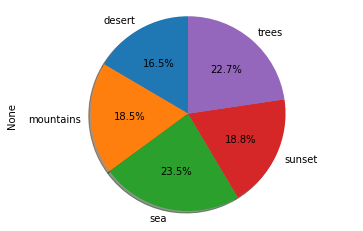

In [6]:
df = pd.read_csv("data.csv")
fig1, ax1 = plt.subplots()
df.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

99.jpg


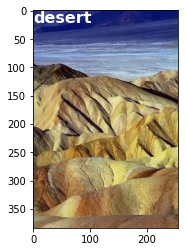

In [7]:
def visualizeImage(idx):
  fd = df.iloc[idx]
  image = fd.image
  label = fd[1:].tolist()
  print(image)
  image = Image.open("original/"+image)
  fig,ax = plt.subplots()
  ax.imshow(image)
  ax.grid(False)
  classes =  np.array(classLabels)[np.array(label,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  plt.show()

visualizeImage(98)

In [8]:
from utils.datasets import MyDataset

In [ ]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset("data.csv" , Path("original") , transform)
valid_no = int(len(dataset)*0.12) 
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

# Model definition


In [11]:
from models import Volume
model = Volume(num_classes=len(classLabels))

# Optimizer and Criterion

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:1')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

# Training

In [14]:
from train import train

In [ ]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=50)

In [ ]:
def createCheckpoint(filename=Path("./2_input_new.pt")):
      checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()